In [3]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import*# QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from scipy import sparse
from scipy.linalg import sqrtm
# Loading your IBM Quantum account(s):
#provider = IBMQ.load_account()

# Discrete Brillouin zone

In [4]:
number_of_mesh_points = 8
# discretizing the BZ into mesh points.
k_x_lst = list(np.linspace(-np.pi,np.pi,number_of_mesh_points))
k_y_lst = list(np.linspace(-np.pi,np.pi,number_of_mesh_points))

# list of all points in the discrete BZ.
discretized_Brillouin_zone = []
for i in range(number_of_mesh_points):
    for j in range(number_of_mesh_points):
        discretized_Brillouin_zone.append([k_x_lst[i],k_y_lst[j]])
# nearest neighbor spacing in the discrete BZ.        
delta_k_x = k_x_lst[1]-k_x_lst[0]
delta_k_y = k_y_lst[1]-k_y_lst[0]        

In [5]:
# the parameter \mu.
mu = 1.95

In [6]:
# Number of points = numnumber_of_mesh_points*number_of_mesh_points
#point_index = 0

In [7]:
r"""
# k_x and k_y
k_x,k_y = k_x_lst[point_index],k_y_lst[point_index]
# k+delta_k_x and k+delta_k_y

F_k_lst_of_points = [[(k_x,k_y),(k_x+delta_k_x,k_y)],
[(k_x+delta_k_x,k_y),(k_x+delta_k_x,k_y+delta_k_y)],
[(k_x,k_y+delta_k_y),(k_x+delta_k_x,k_y+delta_k_y)],
[(k_x,k_y),(k_x,k_y+delta_k_y)]]""";

In [8]:
# Index runs from 0 to 3.
#F_k_index = 2

In [9]:
#k_x,k_y = F_k_lst_of_points[F_k_index][0][0],F_k_lst_of_points[F_k_index][0][1]
#k_x_p,k_y_p = F_k_lst_of_points[F_k_index][1][0],F_k_lst_of_points[F_k_index][1][1]

# Preparation of the wavefunction at point $\mathbf{k}$

## $U_{3}$ gate

In [10]:
# U_{3} is required for preparing the state |\psi(\theta)>
def U3(theta,lamb,phi):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)*np.exp(1j*lamb)],
                     [np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(lamb+phi))*np.cos(theta/2)]])

## Defining the two angles $\theta$ and $\phi$

In [11]:
def angle_theta(k_x,k_y):
    E_p = np.sqrt((np.sin(k_x))**2+(np.sin(k_y))**2+(np.cos(k_x)+np.cos(k_y)+mu)**2)
    return np.arccos((np.cos(k_x)+np.cos(k_y)+mu)/E_p)
def angle_phi(k_x,k_y):
    return np.arccos(np.sin(k_y)/np.sqrt((np.sin(k_y))**2+(np.sin(k_x))**2))

## Controlled W gate required for controlled $U_{3}$ operation

In [28]:
def controlled_W(unitary_matrix,c,t):
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2    
    Matrices = {'I':I,'PI_0':PI_0,'U':unitary_matrix, 'PI_1':PI_1}
    p0 = ['I']*3
    p1 = ['I']*3    
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'U'
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,3):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,3):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)
    return (PI_0_matrix+PI_1_matrix)

## Constructing the upper band wavefunction circuit

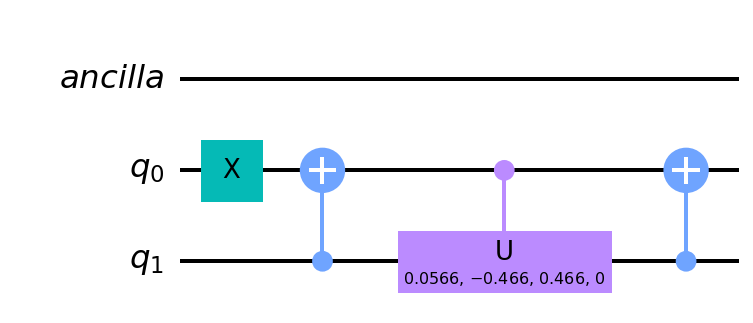

In [23]:
def upper_band_wavefunction(k_x,k_y):
    qr = QuantumRegister(2,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    # Create the quantum circuit
    qc = QuantumCircuit(anc,qr)  
    
    qc.x(1)
    qc.cx(2,1)
    theta = angle_theta(k_x,k_y)
    phi = angle_phi(k_x,k_y)
    qc.cu(theta,-phi,phi,0,1,2)
    qc.cx(2,1)
    return qc
upper_band_wavefunction(0.1,0.2).draw("mpl",scale=2)

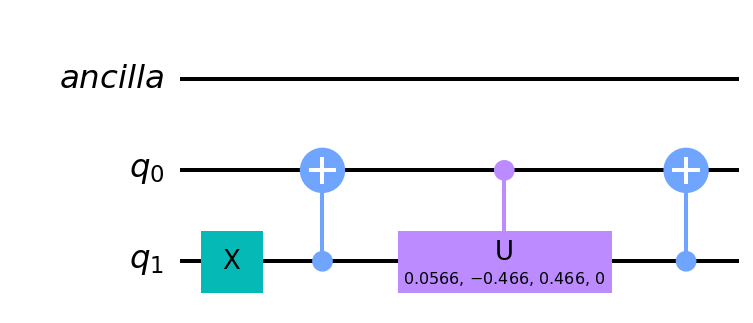

In [26]:
def lower_band_wavefunction(k_x,k_y):
    qr = QuantumRegister(2,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    # Create the quantum circuit
    qc = QuantumCircuit(anc,qr)  
    
    qc.x(2)
    qc.cx(2,1)
    theta = angle_theta(k_x,k_y)
    phi = angle_phi(k_x,k_y)
    
    qc.cu(theta,-phi,phi,0,1,2)
    
    qc.cx(2,1)
    return qc
lower_band_wavefunction(0.1,0.2).draw("mpl",scale=2)

# Relating the wavefunction at two neighboring mesh points

## Intraband evolution circuit

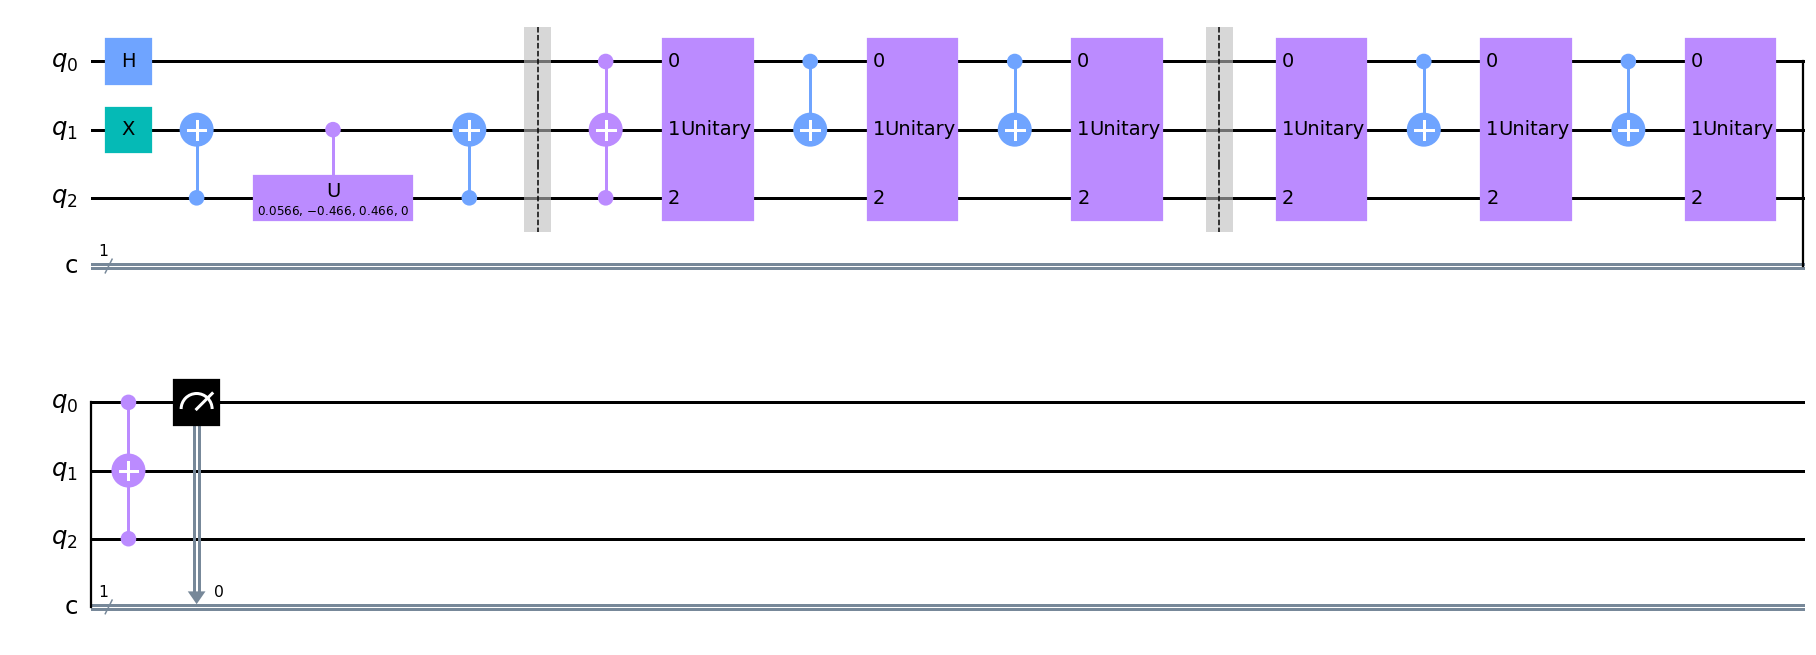

In [31]:
def intraband_evolution(k_x,k_y,k_x_p,k_y_p):

    # create the quantum circuit
    qc = QuantumCircuit(3,1)  
    qc.h(0)
    qc = qc.compose(upper_band_wavefunction(k_x,k_y))    
    
    qc.barrier()
    
    qc.ccx(0,2,1)
    # $CCU_{3}^{\dagger}$ gate.
    W = sqrtm(np.matrix(U3(angle_theta(k_x,k_y),-angle_phi(k_x,k_y),angle_phi(k_x,k_y))).getH())
    qc.unitary(controlled_W(W,1,2).A,[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,1,2).A).getH(),[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,0,2).A).getH(),[0,1,2])
    
    qc.barrier()
    
    # $CCU_{3}$ gate.
    W = sqrtm(U3(angle_theta(k_x_p,k_y_p),-angle_phi(k_x_p,k_y_p),angle_phi(k_x_p,k_y_p)))
    qc.unitary(controlled_W(W,1,2).A,[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,1,2).A).getH(),[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,0,2).A).getH(),[0,1,2])    
    qc.ccx(0,2,1)    
    qc.measure(0,0)
    return qc
intraband_evolution(0.1,0.2,-0.1,-0.3).draw("mpl",scale=1.5)

# Interband evolution circuit

In [14]:
def interband_evolution(k_x,k_y,k_x_p,k_y_p):

    # Create the quantum circuit
    qc = QuantumCircuit(3,1)  
    qc.h(0)
    qc = qc.compose(upper_band_wavefunction(k_x,k_y))    
    
    qc.barrier()
    
    qc.ccx(0,2,1)
    # $CCU_{3}^{\dagger}$ gate.
    W = sqrtm(np.matrix(U3(angle_theta(k_x,k_y),-angle_phi(k_x,k_y),angle_phi(k_x,k_y))).getH())
    qc.unitary(controlled_W(W,1,2).A,[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,1,2).A).getH(),[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,0,2).A).getH(),[0,1,2])
    
    qc.ccx(0,1,2)
    
    # $CCU_{3}$ gate.
    W = sqrtm(U3(angle_theta(k_x_p,k_y_p),-angle_phi(k_x_p,k_y_p),angle_phi(k_x_p,k_y_p)))
    qc.unitary(controlled_W(W,1,2).A,[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,1,2).A).getH(),[0,1,2])
    qc.cx(0,1)
    qc.unitary(np.matrix(controlled_W(W,0,2).A).getH(),[0,1,2])    
    qc.ccx(0,2,1)    
    qc.measure(0,0)
    return qc

In [15]:
#interband_evolution(1,1,1,1).draw()

# Code on simulator

In [16]:
counts_lst = []
for k_1 in k_x_lst:
    for k_2 in k_y_lst:
        F_k_lst_of_points = [[(k_1,k_2),(k_1+delta_k_x,k_2)],
        [(k_1+delta_k_x,k_2),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2+delta_k_y),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2),(k_1,k_2+delta_k_y)]]

        for F_k_index in range(4):
            k_x,k_y = F_k_lst_of_points[F_k_index][0][0],F_k_lst_of_points[F_k_index][0][1]
            k_x_p,k_y_p = F_k_lst_of_points[F_k_index][1][0],F_k_lst_of_points[F_k_index][1][1]
            # Simulating the Circuit:
            backend = Aer.get_backend('qasm_simulator')
            job = execute(intraband_evolution(k_x,k_y,k_x_p,k_y_p), backend, shots = 5120)
            result = job.result()
            counts = result.get_counts()
            counts_lst.append([k_x,k_y,k_x_p,k_y_p,counts["0"],counts["1"]])
            #plot_histogram(counts)

In [17]:
#counts_lst

In [18]:
intraband_evolution(k_x,k_y,k_x_p,k_y_p).depth()

17

# Code on hardware

In [19]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2023-10-03 18:47:33,413: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibm_nairobi


In [1]:
r"""
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
real_hardware_counts_lst = []
for k_1 in k_x_lst:
    for k_2 in k_y_lst:
        F_k_lst_of_points = [[(k_1,k_2),(k_1+delta_k_x,k_2)],
        [(k_1+delta_k_x,k_2),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2+delta_k_y),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2),(k_1,k_2+delta_k_y)]]

        for F_k_index in range(4):
            k_x,k_y = F_k_lst_of_points[F_k_index][0][0],F_k_lst_of_points[F_k_index][0][1]
            k_x_p,k_y_p = F_k_lst_of_points[F_k_index][1][0],F_k_lst_of_points[F_k_index][1][1]
            transpiled_circuit = transpile(intraband_evolution(k_x,k_y,k_x_p,k_y_p), device, optimization_level=3)
            job = device.run(transpiled_circuit)
            job_monitor(job, interval=2)
            # Getting the results from the computation:
            results = job.result()
            answer = results.get_counts(transpiled_circuit)
            #plot_histogram(answer)
            real_hardware_counts_lst.append([k_x,k_y,k_x_p,k_y_p,answer["0"],answer["1"]])""";

In [ ]:
#real_hardware_counts_lst

In [ ]:
# Getting the results from the computation:
#results = job.result()
#answer = results.get_counts(transpiled_circuit)
#plot_histogram(answer)